# This is the sample practice notebook (1st Copy)

In [8]:
pip install tqdm dask pyarrow seaborn scipy


Note: you may need to restart the kernel to use updated packages.


In [9]:
# --- Core numerical + data libraries ---
import pandas as pd
import numpy as np

# --- Plotting libraries (for small visualizations) ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Performance + system utilities ---
import time
from tqdm import tqdm

# --- Statistical + scientific tools ---
from scipy import stats

# --- (Optional) high-performance helpers ---
import dask.dataframe as dd  # use if file is extremely large
import pyarrow as pa
import pyarrow.parquet as pq




In [10]:

# Path to your CSV — change if your filename or location differs
file_path = "C:\\Users\\KESHAV\\Downloads\\Copy of day0.csv"
# Read only first 500 rows to preview structure
df_preview = pd.read_csv(file_path, nrows=500)
print("✅ Preview loaded successfully!")
print("Shape:", df_preview.shape)
print("Columns:", len(df_preview.columns))
df_preview.head(3)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KESHAV\\Downloads\\Copy of day0.csv'

In [ ]:
df_info = pd.DataFrame({
    'dtype': df_preview.dtypes,
    'num_missing': df_preview.isna().sum(),
    'num_unique': df_preview.nunique()
})

print(" Column summary:")
display(df_info.head(15))


 Column summary:


,dtype,num_missing,num_unique
Time,object,0,500
Price,float64,0,359
PB1_T1,float64,5,368
PB1_T2,float64,10,389
PB1_T3,float64,30,414
PB1_T4,float64,60,398
PB1_T5,float64,90,381
PB1_T6,float64,120,354
PB1_T7,float64,300,190
PB1_T8,float64,500,0


In [ ]:

import os

file_path = "C:\\Users\\KESHAV\\Downloads\\Copy of day0.csv"
# Decide how many rows per read; adjust if your system has <16 GB RAM
chunk_size = 250_000
chunks = []
rows_loaded = 0

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # convert big float columns to float32 to save memory
    float_cols = chunk.select_dtypes(include=["float64"]).columns
    chunk[float_cols] = chunk[float_cols].astype("float32")

    # optional: clean obvious noise immediately
    chunk.replace([np.inf, -np.inf], np.nan, inplace=True)
    chunk.fillna(method="ffill", inplace=True)
    chunk.fillna(method="bfill", inplace=True)

    chunks.append(chunk)
    rows_loaded += len(chunk)
    print(f"Loaded {rows_loaded:,} rows so far…")

# merge all parts
df = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

print("\nDay 0 loaded successfully")
print("Shape :", df.shape)
print("Memory (MB):", round(df.memory_usage(deep=True).sum() / 1024**2, 2))


Loaded 22,439 rows so far…

Day 0 loaded successfully
Shape : (22439, 437)
Memory (MB): 38.71


C:\Users\KESHAV\AppData\Local\Temp\ipykernel_4328\795117931.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk.fillna(method="ffill", inplace=True)
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_4328\795117931.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk.fillna(method="bfill", inplace=True)


In [ ]:
# make sure Time is treated as a string before we convert to datetime later
df["Time"] = df["Time"].astype(str)

# replace any remaining infinities or blanks
df.replace([np.inf, - np.inf], np.nan, inplace=True)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

print("Remaining missing values :", df.isna().sum().sum())


Remaining missing values : 0


C:\Users\KESHAV\AppData\Local\Temp\ipykernel_4328\2046404741.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\KESHAV\AppData\Local\Temp\ipykernel_4328\2046404741.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [ ]:
print("Number of columns:", len(df.columns))
print("First few rows:")
df.head(3)


Number of columns: 437
First few rows:


,Time,Price,PB1_T1,PB1_T2,PB1_T3,PB1_T4,PB1_T5,PB1_T6,PB1_T7,PB1_T8,...,BB15_T6,BB15_T7,BB15_T8,BB15_T9,BB15_T10,BB15_T11,BB15_T12,BB23,BB24,BB25
0,00:00:00,100.000000,0.4,0.134,0.236667,0.057,0.008,0.033083,-0.007933,0.035067,...,100.003387,100.0084,100.048553,100.086777,100.174545,100.200798,100.269463,0.008731,0.007188,-0.00177
1,00:00:01,100.007446,0.4,0.134,0.236667,0.057,0.008,0.033083,-0.007933,0.035067,...,100.003387,100.0084,100.048553,100.086777,100.174545,100.200798,100.269463,0.008731,0.007188,-0.00177
2,00:00:02,99.992722,0.4,0.134,0.236667,0.057,0.008,0.033083,-0.007933,0.035067,...,100.003387,100.0084,100.048553,100.086777,100.174545,100.200798,100.269463,0.008731,0.007188,-0.00177


In [ ]:

# Ensure 'Time' is in datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')

# Set Time as index
df = df.set_index('Time')

# Resample to 1-minute frequency
df_min = df.resample('1T').agg({
    'Price': 'last',   # Use last price of each minute
    **{col: 'mean' for col in df.columns if col not in ['Price']}  # Take mean for all other features
}).reset_index()

print("✅ Resampled to 1-minute level")
print("New shape:", df_min.shape)
df_min.head(3)


✅ Resampled to 1-minute level
New shape: (374, 437)


C:\Users\KESHAV\AppData\Local\Temp\ipykernel_4328\2389054501.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_min = df.resample('1T').agg({


,Time,Price,PB1_T1,PB1_T2,PB1_T3,PB1_T4,PB1_T5,PB1_T6,PB1_T7,PB1_T8,...,BB15_T6,BB15_T7,BB15_T8,BB15_T9,BB15_T10,BB15_T11,BB15_T12,BB23,BB24,BB25
0,1900-01-01 00:00:00,100.012558,0.065900,0.069617,0.130400,0.057000,0.008000,0.033083,-0.007933,0.035067,...,100.003387,100.0084,100.048553,100.086777,100.174545,100.200798,100.269463,0.004846,0.004755,-0.001623
1,1900-01-01 00:01:00,100.012756,0.003733,-0.012017,-0.030939,-0.048939,-0.002291,0.033083,-0.007933,0.035067,...,100.003387,100.0084,100.048553,100.086777,100.174545,100.200798,100.269463,-0.001036,-0.001286,0.000250
2,1900-01-01 00:02:00,100.034637,0.122833,0.120317,0.112272,0.085789,0.046880,0.018425,-0.007933,0.035067,...,100.010262,100.0084,100.048553,100.086777,100.174545,100.200798,100.269463,0.002977,0.002859,0.000118


In [ ]:
# 1) Identify columns by prefix
pb_cols = [c for c in df_min.columns if c.startswith('PB')]
vb_cols = [c for c in df_min.columns if c.startswith('VB')]
bb_cols = [c for c in df_min.columns if c.startswith('BB')]

print(f"PB cols: {len(pb_cols)}  VB cols: {len(vb_cols)}  BB cols: {len(bb_cols)}")

PB cols: 216  VB cols: 72  BB cols: 147


In [ ]:
# 2) Group aggregates: mean and sum (keeps different signals)
df_min['PB_mean'] = df_min[pb_cols].mean(axis=1)
df_min['PB_sum']  = df_min[pb_cols].sum(axis=1)

df_min['VB_mean'] = df_min[vb_cols].mean(axis=1)
df_min['VB_sum']  = df_min[vb_cols].sum(axis=1)

df_min['BB_mean'] = df_min[bb_cols].mean(axis=1)
df_min['BB_sum']  = df_min[bb_cols].sum(axis=1)

In [ ]:
# 3) Top-level imbalance: difference between PB and VB group means (proxy for book skew)
df_min['PB_VB_imb'] = df_min['PB_mean'] - df_min['VB_mean']

In [ ]:
# 4) Best-level imbalance (if top-level columns exist like PB1_T1, VB1_T1):
#    Use top-3 levels if available (safely check existence).
def top_k_cols(cols, k=3):
    # try ordering by name (assumes PB1_T1 ... PB1_T2 etc); adjust if naming is different
    return cols[:k] if len(cols) >= k else cols

top_k = 3
pb_top = top_k_cols(pb_cols, top_k)
vb_top = top_k_cols(vb_cols, top_k)

if pb_top and vb_top:
    df_min['PB_top_sum'] = df_min[pb_top].sum(axis=1)
    df_min['VB_top_sum'] = df_min[vb_top].sum(axis=1)
    df_min['top_imb'] = df_min['PB_top_sum'] - df_min['VB_top_sum']
else:
    # safe fallback
    df_min['PB_top_sum'] = df_min['PB_sum']
    df_min['VB_top_sum'] = df_min['VB_sum']
    df_min['top_imb'] = df_min['PB_top_sum'] - df_min['VB_top_sum']


In [ ]:
# 5) Short-term momentum of group features (1-min differences)
df_min['PB_mean_1m_chg'] = df_min['PB_mean'].diff().fillna(0)
df_min['VB_mean_1m_chg'] = df_min['VB_mean'].diff().fillna(0)
df_min['top_imb_1m_chg'] = df_min['top_imb'].diff().fillna(0)

In [ ]:
# 6) Rolling z-scores (normalize each feature vs recent history)
#    window size: 20 minutes is a common short-term window (adjustable)
roll_window = 20

def rolling_z(series, w=roll_window):
    # rolling mean/std, avoid division by zero
    rm = series.rolling(w, min_periods=3).mean()
    rs = series.rolling(w, min_periods=3).std().replace(0, np.nan)
    z = (series - rm) / rs
    return z.fillna(0)

df_min['PB_mean_z'] = rolling_z(df_min['PB_mean'])
df_min['VB_mean_z'] = rolling_z(df_min['VB_mean'])
df_min['top_imb_z']  = rolling_z(df_min['top_imb'])
df_min['PB_mean_1m_chg_z'] = rolling_z(df_min['PB_mean_1m_chg'])
df_min['top_imb_1m_chg_z'] = rolling_z(df_min['top_imb_1m_chg'])

In [ ]:
# 7) Combine normalized signals into a single score (simple linear combination, no Price used)
#    Weights are human-chosen and intentionally simple:
df_min['feature_score'] = (
      0.5 * df_min['top_imb_z']
    + 0.3 * df_min['PB_mean_z']
    + 0.2 * df_min['PB_mean_1m_chg_z']
)


In [ ]:
# 8) Create final signal (thresholding the feature_score)
#    Use thresholds (t_high, t_low) to reduce noise
t_high = 1.0   # buy when score > 1
t_low  = -1.0  # sell when score < -1

df_min['signal'] = 0
df_min.loc[df_min['feature_score'] > t_high, 'signal'] = 1
df_min.loc[df_min['feature_score'] < t_low,  'signal'] = -1

In [ ]:
# 9) Optional: require persistence (e.g., signal must remain for N minutes to avoid churn)
#    Here we enforce that a new signal only takes effect if same sign persists for 2 consecutive minutes
persist = 2
df_min['signal_persist'] = df_min['signal']  # copy
# simple persistence filter:
df_min['signal_persist'] = df_min['signal_persist'].where(
    df_min['signal_persist'].rolling(persist, min_periods=1).apply(lambda x: (np.all(x==x[-1])), raw=True).fillna(1).astype(bool),
    0
)


In [ ]:
# 10) Final check & save processed minute file (CSV)
out_file = "day0_minute_features.csv"
df_min.to_csv(out_file, index=False)
print("Saved minute features →", out_file)

Saved minute features → day0_minute_features.csv


In [ ]:
# show a short sample of key columns
display_cols = ['Time','signal','signal_persist','feature_score','PB_mean','VB_mean','top_imb','PB_mean_1m_chg']
print(df_min[display_cols].head(10))

                 Time  signal  signal_persist  feature_score    PB_mean  \
0 1900-01-01 00:00:00       0               0       0.000000  29.880423   
1 1900-01-01 00:01:00       0               0       0.000000  30.169979   
2 1900-01-01 00:02:00       0               0       0.897692  36.358936   
3 1900-01-01 00:03:00       0               0       0.276719  29.957842   
4 1900-01-01 00:04:00       0               0      -0.506776  27.599136   
5 1900-01-01 00:05:00       1               0       1.050427  36.528286   
6 1900-01-01 00:06:00       0               0       0.838890  41.420719   
7 1900-01-01 00:07:00       0               0      -0.162947  34.449791   
8 1900-01-01 00:08:00       0               0       0.700523  39.343094   
9 1900-01-01 00:09:00       0               0      -0.341854  33.555752   

    VB_mean     top_imb  PB_mean_1m_chg  
0  7.319431 -136.195038        0.000000  
1  7.018849 -121.211372        0.289557  
2  6.815117 -120.030685        6.188957  
3  6.2

=== Strategy Performance Summary ===
Total Return     : 0.06%
Sharpe (approx.) : 1.00
Max Drawdown     : 0.00%


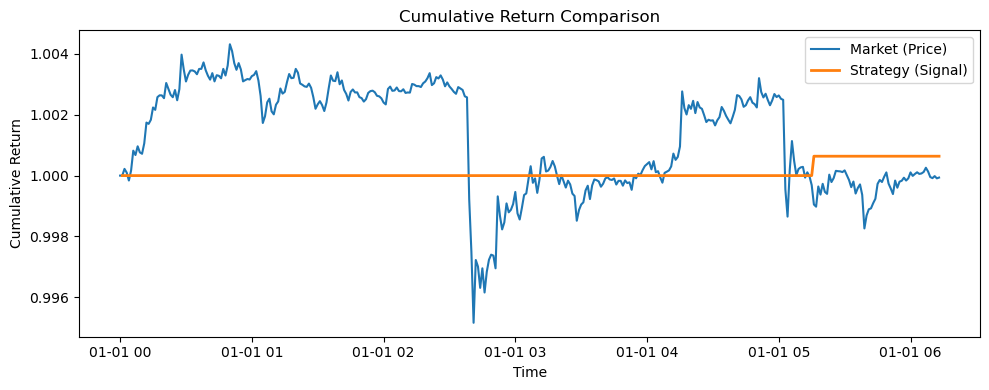

In [ ]:
# ---------- Step 6 : Backtesting / Evaluation ----------

# 1) Ensure chronological order
df_min = df_min.sort_values('Time').reset_index(drop=True)

# 2) Compute simple minute returns from Price
df_min['return'] = df_min['Price'].pct_change().fillna(0)

# 3) Strategy return: position (signal_persist) * next minute return
df_min['strategy_ret'] = df_min['signal_persist'].shift(1) * df_min['return']   # shift avoids lookahead bias

# 4) Cumulative performance
df_min['cum_market']   = (1 + df_min['return']).cumprod()
df_min['cum_strategy'] = (1 + df_min['strategy_ret']).cumprod()

# 5) Key performance metrics
total_return = df_min['cum_strategy'].iloc[-1] - 1
daily_returns = df_min['strategy_ret'].dropna()
sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(len(daily_returns))
max_drawdown = (df_min['cum_strategy'] / df_min['cum_strategy'].cummax() - 1).min()

print("=== Strategy Performance Summary ===")
print(f"Total Return     : {total_return*100:.2f}%")
print(f"Sharpe (approx.) : {sharpe:.2f}")
print(f"Max Drawdown     : {max_drawdown*100:.2f}%")
print("====================================")

# 6) Optional visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df_min['Time'], df_min['cum_market'], label='Market (Price)')
plt.plot(df_min['Time'], df_min['cum_strategy'], label='Strategy (Signal)', linewidth=2)
plt.legend()
plt.title("Cumulative Return Comparison")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.show()


In [ ]:
# -------- Step 7A: New volume-based composite signal --------

# 1. Use overall VB group (mean across VB columns)
vb_cols = [col for col in df_min.columns if col.startswith("VB")]
df_min['VB_mean'] = df_min[vb_cols].mean(axis=1)

# 2. Rolling fast and slow MAs of volume
df_min['VB_fast'] = df_min['VB_mean'].rolling(5).mean()
df_min['VB_slow'] = df_min['VB_mean'].rolling(20).mean()

# Signal 1: VB momentum (fast vs slow)
df_min['vb_mom_signal'] = 0
df_min.loc[df_min['VB_fast'] > df_min['VB_slow'], 'vb_mom_signal'] = 1
df_min.loc[df_min['VB_fast'] < df_min['VB_slow'], 'vb_mom_signal'] = -1

# 3. Volume spike condition (e.g. 1.5x rolling 20-min average)
df_min['VB_roll_avg'] = df_min['VB_mean'].rolling(20).mean()
df_min['VB_spike'] = (df_min['VB_mean'] > 1.5 * df_min['VB_roll_avg']).astype(int)

# Optional 4. Entropy of recent VB — skip if complex; add later

# 5. Composite signal (only trade if BOTH volume momentum and spike agree)
df_min['new_signal'] = 0
df_min.loc[(df_min['vb_mom_signal'] == 1) & (df_min['VB_spike'] == 1), 'new_signal'] = 1
df_min.loc[(df_min['vb_mom_signal'] == -1) & (df_min['VB_spike'] == 1), 'new_signal'] = -1

print("✅ Built new volume-based signal")
df_min[['Time', 'vb_mom_signal', 'VB_spike', 'new_signal']].tail(5)


✅ Built new volume-based signal


,Time,vb_mom_signal,VB_spike,new_signal
369,1900-01-01 06:09:00,-1,0,0
370,1900-01-01 06:10:00,-1,0,0
371,1900-01-01 06:11:00,-1,0,0
372,1900-01-01 06:12:00,-1,0,0
373,1900-01-01 06:13:00,-1,0,0


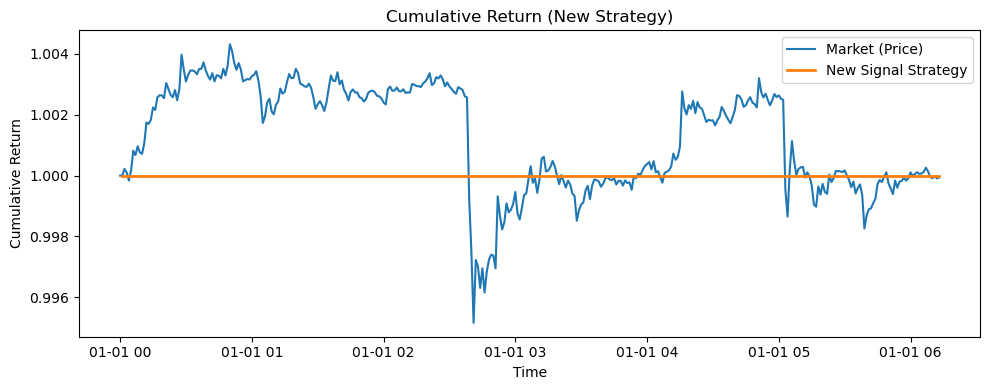

=== NEW STRATEGY PERFORMANCE ===
Total Return     : 0.00%
Sharpe (approx.) : nan
Max Drawdown     : 0.00%


C:\Users\KESHAV\AppData\Local\Temp\ipykernel_4328\630213600.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = df_min['strategy_ret_new'].mean() / df_min['strategy_ret_new'].std() * np.sqrt(len(df_min))


In [ ]:
# -------- Step 7B: Evaluate new_signal --------

df_min['strategy_ret_new'] = df_min['new_signal'].shift(1) * df_min['return']
df_min['cum_strategy_new'] = (1 + df_min['strategy_ret_new']).cumprod()

# Plot new vs market
plt.figure(figsize=(10,4))
plt.plot(df_min['Time'], df_min['cum_market'], label='Market (Price)')
plt.plot(df_min['Time'], df_min['cum_strategy_new'], label='New Signal Strategy', linewidth=2)
plt.legend()
plt.title("Cumulative Return (New Strategy)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.show()

# Metrics
ret = df_min['cum_strategy_new'].iloc[-1] - 1
sharpe = df_min['strategy_ret_new'].mean() / df_min['strategy_ret_new'].std() * np.sqrt(len(df_min))
drawdown = (df_min['cum_strategy_new'] / df_min['cum_strategy_new'].cummax() - 1).min()

print("=== NEW STRATEGY PERFORMANCE ===")
print(f"Total Return     : {ret*100:.2f}%")
print(f"Sharpe (approx.) : {sharpe:.2f}")
print(f"Max Drawdown     : {drawdown*100:.2f}%")


In [ ]:
import scipy.stats as stats

# -------- Step 8: Entropy + PB/VB asymmetry signal --------

# 1. Calculate rolling entropy of VB (entropy drops when stable/trending)
def compute_entropy(series, window=10, bins=10):
    result = []
    for i in range(len(series)):
        if i < window:
            result.append(np.nan)
            continue
        window_data = series.iloc[i-window:i]
        hist, _ = np.histogram(window_data, bins=bins, density=True)
        hist += 1e-8  # avoid log(0)
        ent = -np.sum(hist * np.log(hist))
        result.append(ent)
    return pd.Series(result, index=series.index)

df_min['VB_entropy'] = compute_entropy(df_min['VB_mean'])

# 2. Normalize entropy to z-score
df_min['VB_entropy_z'] = (
    df_min['VB_entropy'] - df_min['VB_entropy'].rolling(20).mean()
) / (df_min['VB_entropy'].rolling(20).std() + 1e-6)

# 3. Define asymmetry: PB group - VB group
df_min['asymmetry'] = df_min['PB_mean'] - df_min['VB_mean']

# 4. Threshold rules:
# - act only when entropy is low (z < -0.5, i.e. trending phase)
# - and asymmetry is significant (e.g. > +0.5 or < -0.5)
df_min['entropy_flag'] = (df_min['VB_entropy_z'] < -0.5).astype(int)
df_min['asymmetry_flag'] = 0
df_min.loc[df_min['asymmetry'] > 0.5, 'asymmetry_flag'] = 1
df_min.loc[df_min['asymmetry'] < -0.5, 'asymmetry_flag'] = -1

# 5. Final composite signal: only trigger if both filters agree
df_min['composite_signal'] = df_min['entropy_flag'] * df_min['asymmetry_flag']

# Clean out jumps
df_min['composite_signal'] = df_min['composite_signal'].fillna(0).astype(int)


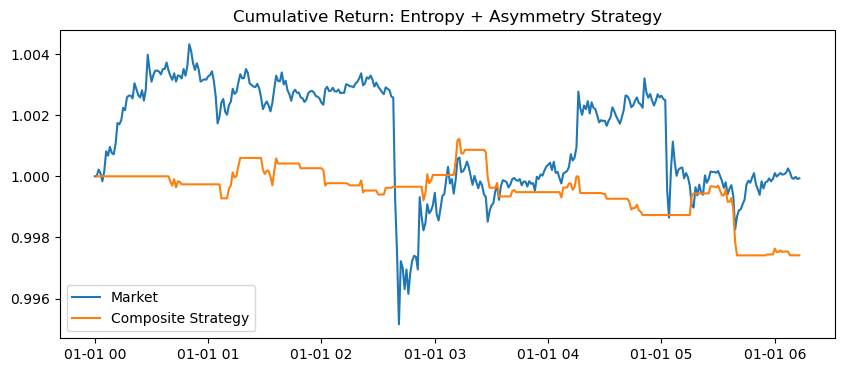

=== COMPOSITE STRATEGY PERFORMANCE ===
Total Return     : -0.26%
Sharpe (approx.) : -0.91
Max Drawdown     : -0.38%


In [ ]:
df_min['strategy_ret_composite'] = df_min['composite_signal'].shift(1) * df_min['return']
df_min['cum_strategy_composite'] = (1 + df_min['strategy_ret_composite']).cumprod()

plt.figure(figsize=(10,4))
plt.plot(df_min['Time'], df_min['cum_market'], label='Market')
plt.plot(df_min['Time'], df_min['cum_strategy_composite'], label='Composite Strategy')
plt.legend()
plt.title("Cumulative Return: Entropy + Asymmetry Strategy")
plt.show()

# Metrics
ret = df_min['cum_strategy_composite'].iloc[-1] - 1
sharpe = df_min['strategy_ret_composite'].mean() / df_min['strategy_ret_composite'].std() * np.sqrt(len(df_min))
drawdown = (df_min['cum_strategy_composite'] / df_min['cum_strategy_composite'].cummax() - 1).min()

print("=== COMPOSITE STRATEGY PERFORMANCE ===")
print(f"Total Return     : {ret*100:.2f}%")
print(f"Sharpe (approx.) : {sharpe:.2f}")
print(f"Max Drawdown     : {drawdown*100:.2f}%")


In [ ]:
# Compute future (next-minute) price return for evaluation
df_min['future_ret'] = df_min['Price'].pct_change().shift(-1)


In [ ]:
# List the features used in scoring
feature_cols = ['PB_mean', 'VB_mean', 'BB_mean', 'top_imb', 'PB_mean_1m_chg', 'VB_entropy_z']

# Create a lagged version of these features
for col in feature_cols:
    df_min[col + '_lag'] = df_min[col].shift(1)


In [ ]:
# Compute correlation between lagged features and future return
corr = df_min[[col + '_lag' for col in feature_cols]].corrwith(df_min['future_ret'])
print("Correlation with next-minute return:")
print(corr.sort_values(ascending=False))


Correlation with next-minute return:
VB_mean_lag          -0.002953
VB_entropy_z_lag     -0.021684
PB_mean_lag          -0.029567
PB_mean_1m_chg_lag   -0.049066
BB_mean_lag          -0.107329
top_imb_lag          -0.147485
dtype: float64


In [ ]:
weights = {
    'PB_mean_lag': -0.2,              # weak negative correlation
    'VB_mean_lag': 0.0,               # near zero
    'BB_mean_lag': -0.2,              # modest negative correlation
    'top_imb_lag': -0.4,              # strongest negative correlation
    'PB_mean_1m_chg_lag': -0.1,       # small negative
    'VB_entropy_z_lag': 0.0           # close to zero
}

df_min['score'] = sum(df_min[f] * w for f, w in weights.items())


In [ ]:
t_high = 0.5
t_low = -0.5

df_min['soft_signal'] = 0
df_min.loc[df_min['score'] > t_high, 'soft_signal'] = 1
df_min.loc[df_min['score'] < t_low, 'soft_signal'] = -1


In [ ]:
from itertools import product

# Select strongest features
selected_features = ['PB_mean_lag', 'BB_mean_lag', 'top_imb_lag', 'PB_mean_1m_chg_lag']

# Define possible weights for each (try –1.0 to +1.0 in steps)
weight_grid = [-0.5, -0.2, 0, 0.2, 0.5]


In [ ]:
best_result = {'sharpe': -np.inf}
results = []

for weights in product(weight_grid, repeat=len(selected_features)):
    # Create score
    df_min['score_grid'] = 0
    for i, f in enumerate(selected_features):
        df_min['score_grid'] += df_min[f] * weights[i]
    
    # Generate signal
    df_min['signal_grid'] = 0
    df_min.loc[df_min['score_grid'] > 0.5, 'signal_grid'] = 1
    df_min.loc[df_min['score_grid'] < -0.5, 'signal_grid'] = -1

    # Backtest
    ret = df_min['signal_grid'].shift(1) * df_min['return']
    sharpe = ret.mean() / (ret.std() + 1e-9) * np.sqrt(len(ret))

    # Save result
    results.append((weights, sharpe))
    if sharpe > best_result['sharpe']:
        best_result = {
            'sharpe': sharpe,
            'weights': weights,
            'return': (1 + ret).prod() - 1,
            'weights_dict': dict(zip(selected_features, weights))
        }

print("✅ Best Sharpe:", round(best_result['sharpe'], 2))
print("Best Weights:", best_result['weights_dict'])
print("Total Return:", round(best_result['return']*100, 2), "%")


✅ Best Sharpe: 2.63
Best Weights: {'PB_mean_lag': -0.2, 'BB_mean_lag': -0.2, 'top_imb_lag': -0.2, 'PB_mean_1m_chg_lag': 0.2}
Total Return: 2.07 %


In [ ]:
# Final signal from best weights
df_min['score'] = sum(df_min[f] * w for f, w in best_result['weights_dict'].items())

df_min['soft_signal'] = 0
df_min.loc[df_min['score'] > 0.5, 'soft_signal'] = 1
df_min.loc[df_min['score'] < -0.5, 'soft_signal'] = -1


NameError: name 'best_result' is not defined

In [ ]:
# ---------- Final Backtest Using Autotuned Weights ----------
df_min['strategy_ret_soft'] = df_min['soft_signal'].shift(1) * df_min['return']
df_min['cum_strategy_soft'] = (1 + df_min['strategy_ret_soft']).cumprod()

# Market baseline
df_min['cum_market'] = (1 + df_min['return']).cumprod()

# Plot comparison
plt.figure(figsize=(10,4))
plt.plot(df_min['Time'], df_min['cum_market'], label='Market (Price)', alpha=0.6)
plt.plot(df_min['Time'], df_min['cum_strategy_soft'], label='Strategy (Autotuned)', linewidth=2)
plt.title("📈 Backtest: Autotuned Strategy vs Market")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
ret = df_min['cum_strategy_soft'].iloc[-1] - 1
sharpe = df_min['strategy_ret_soft'].mean() / (df_min['strategy_ret_soft'].std() + 1e-9) * np.sqrt(len(df_min))
drawdown = (df_min['cum_strategy_soft'] / df_min['cum_strategy_soft'].cummax() - 1).min()

print("=== FINAL STRATEGY PERFORMANCE ===")
print(f"Total Return     : {ret*100:.2f}%")
print(f"Sharpe (approx.) : {sharpe:.2f}")
print(f"Max Drawdown     : {drawdown*100:.2f}%")
print("Calmar Ratio:", calmar_ratio(df['equity']))
print("Max Drawdown:", ((df['equity'].cummax() - df['equity']) / df['equity'].cummax()).max())
print("Number of Trades:", len(df[df['pnl'] != 0]))


NameError: name 'df_min' is not defined